In [66]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal.windows as win

In [67]:
sample_freq = 44100
abtast_interval = 1/sample_freq

In [68]:
def read_audio(file: str):
    data = np.load(file)
    return data / 1e8

(112640,)
0.20070724899122902


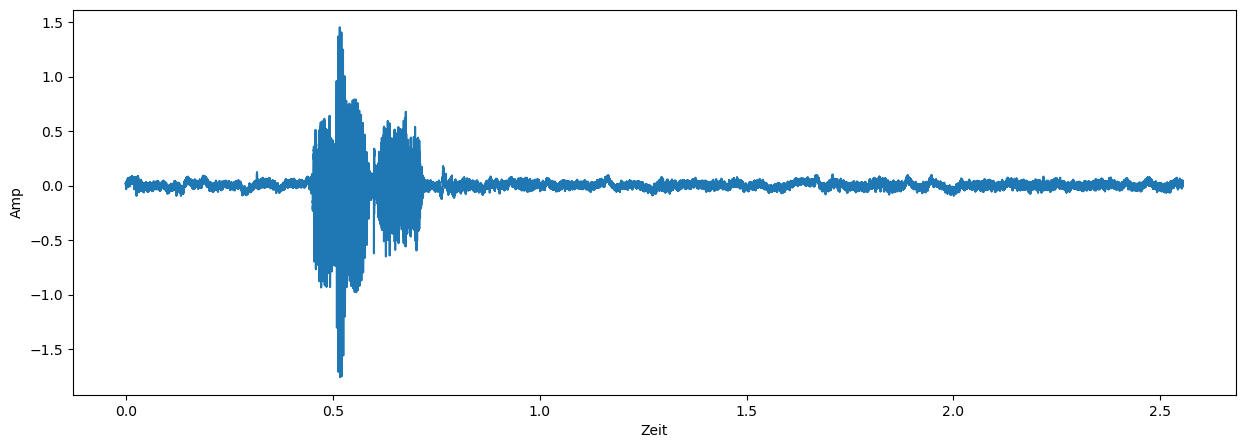

In [69]:
audio_file = "./aufnahme/kevin/links/links_0.npy"
test_signal = read_audio(audio_file)
print(test_signal.shape)

fig, ax = plt.subplots(figsize=(15,5))
ax.set_ylabel("Amp")
ax.set_xlabel("Zeit")

ax.plot(np.linspace(0,len(test_signal)/sample_freq,num=len(test_signal)), test_signal)

cutoff_point = np.std(test_signal) * 1.7
print(cutoff_point)

In [70]:
def read_audio(file: str):
    data = np.load(file)
    cutoff_point = np.std(data) * 2.2
    start_index = np.argmax((data > cutoff_point) | (data < -cutoff_point))
    end_index = start_index + sample_freq # 44100 sample freq
    return data[start_index:end_index] / 1e8

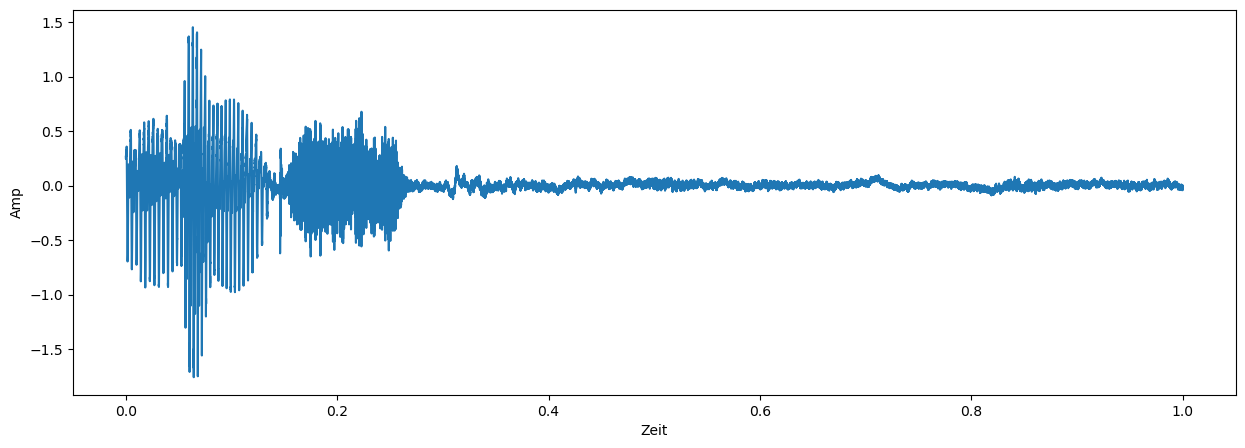

In [71]:
cut = read_audio(audio_file)

fig, ax = plt.subplots(figsize=(15,5))
ax.set_ylabel("Amp")
ax.set_xlabel("Zeit")
ax.plot(np.linspace(0, 1, num=sample_freq), cut)

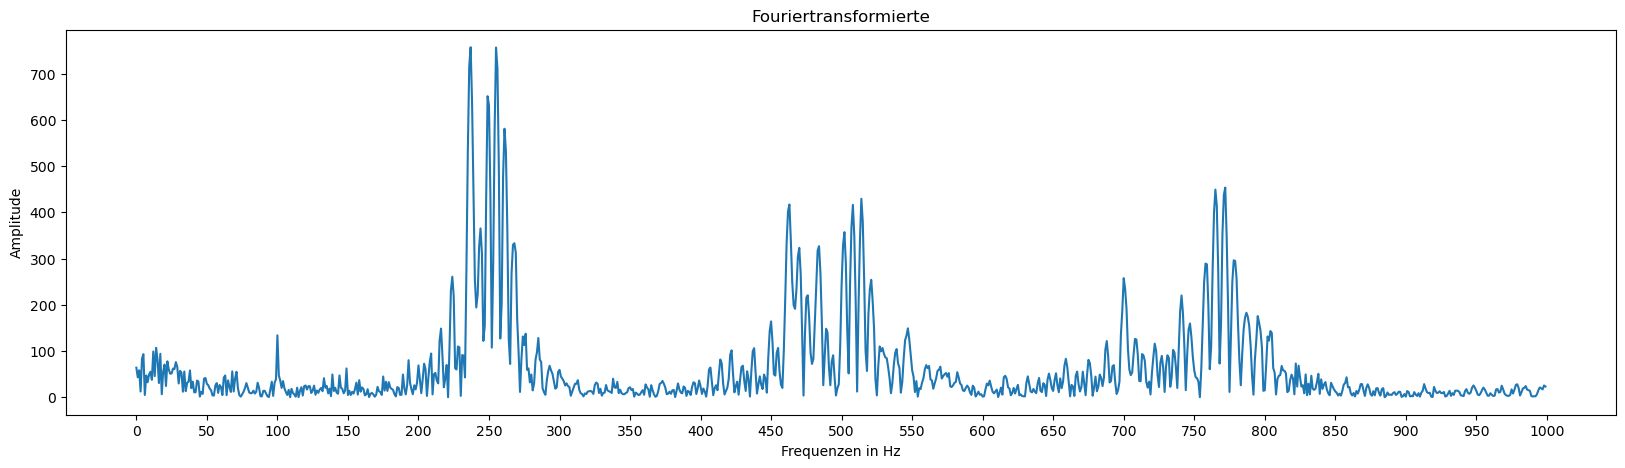

In [72]:
F = np.fft.fft(cut)
freq = np.fft.fftfreq(cut.size, d=abtast_interval)

fig, axl = plt.subplots(figsize=(20, 5))

freqc = freq[:1000]
Fc = F.real[:1000]
axl.set_title("Fouriertransformierte")
axl.set_xlabel("Frequenzen in Hz")
axl.set_ylabel("Amplitude")
axl.locator_params(axis="x", nbins=40)
axl.plot(freqc, np.abs(Fc))

# Windows

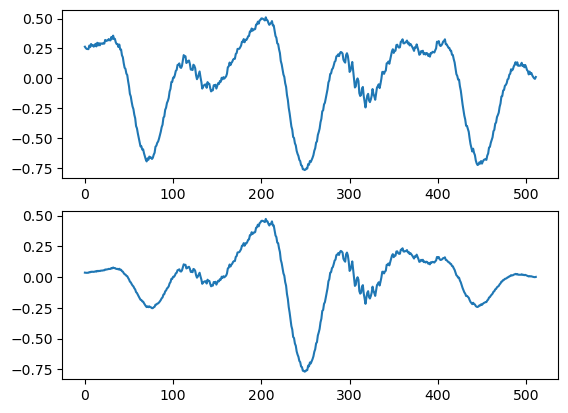

In [73]:
fig, (ax1, ax2) = plt.subplots(2)
window = win.gaussian(512, 512/4)
ax1.plot(cut[:512])
ax2.plot(cut[:512]*window)

In [74]:
segments = []

part = 512
while part < cut.size:
    segments.append(cut[part-512:part] * window)
    part += 256

segments = np.array(segments)
print(segments.shape)

F_segments = []

for n in range(0, len(segments)):
    F_segments.append(np.abs(np.fft.fft(segments[n])))

F_segments = np.array(F_segments)
print(F_segments.shape)

mean_segments = []
for n in range(0, 512):
    mean_segments.append(np.mean(F_segments[:,n])) # abs oder ^2 mitteln
mean_segments = np.array(mean_segments)

(171, 512)
(171, 512)


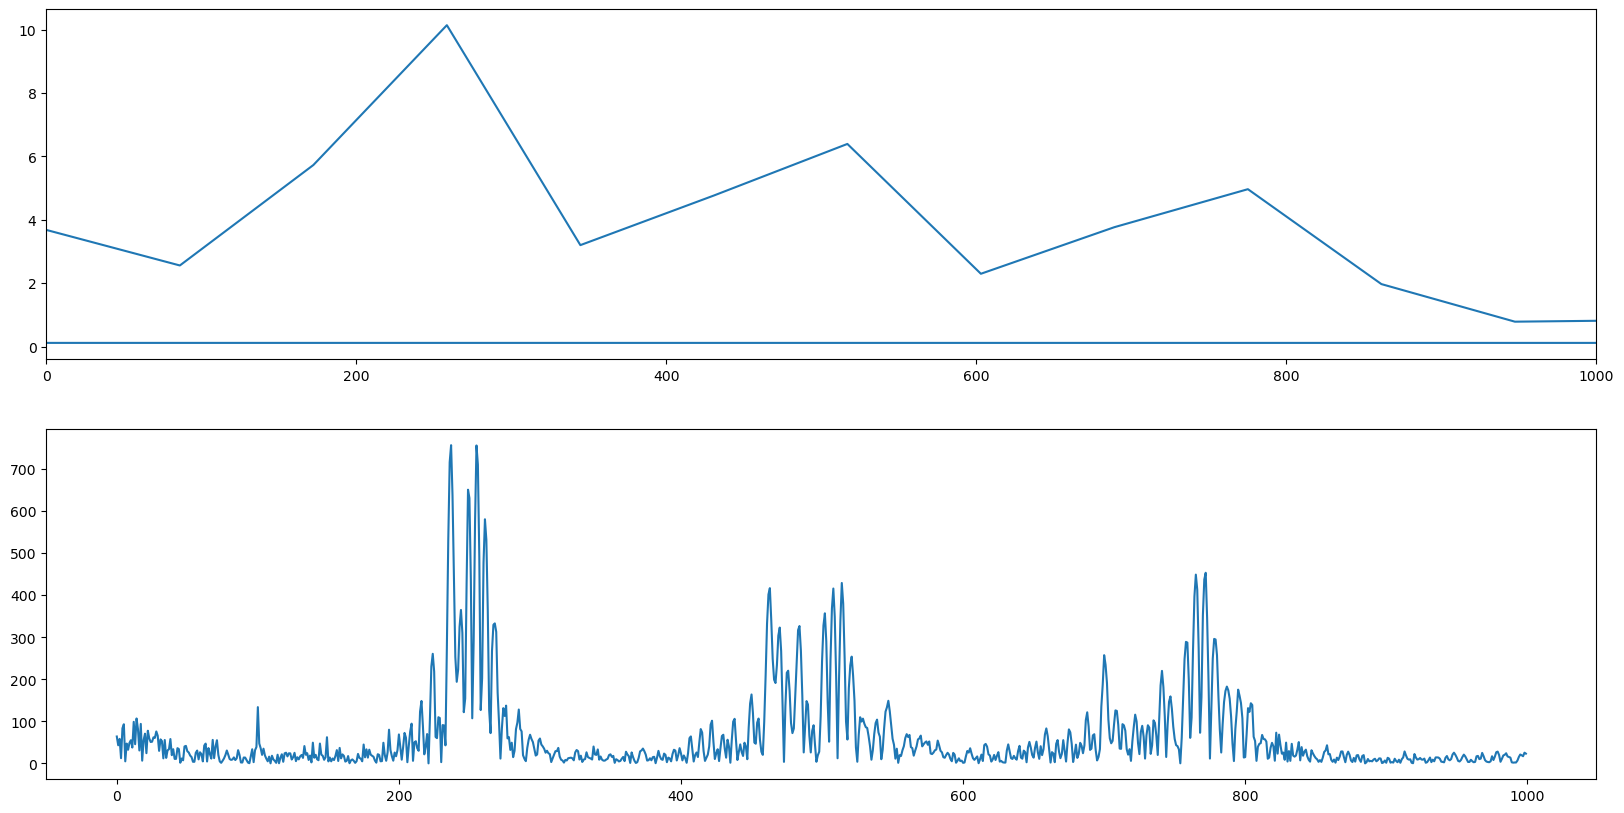

In [75]:
abtastintervall = (512/44100) / 512
F_hz = np.fft.fftfreq(512, d=abtastintervall)

fig,(ax1,ax2) = plt.subplots(2, figsize=(20,10))

ax2.plot(freqc, np.abs(Fc))

freqc1 = F_hz[:1000]
Fc1 = mean_segments.real[:1000]

ax1.set_xlim(0, 1000)
ax1.plot(freqc1, np.abs(Fc1))

# 2 Spracherkennung

In [76]:
# Referenzspektren ermitteln

names = (["hoch", "tief", "links", "rechts"])

signallaenge = 44019
ref_hoch = []
ref_tief = []
ref_links = []
ref_rechts = []

refs = ([ref_hoch, ref_tief, ref_links, ref_rechts])

# Anwendung der Windowing Methode

window = win.gaussian(signallaenge,signallaenge/4)

for name in names:
    spec = []
    for i in range(1,6):

        signal = read_audio("aufnahme/kevin/{0}/{0}_{1}.npy".format(name, str(i))) 

        index = 0
        for idx, x in enumerate(signal):
            if x > 0.5:
                index = idx
                break

        index_ende = index + signallaenge
        signal = np.asarray(signal[index:index_ende])


        spec.append(window*signal)
    
    spec = np.asarray(spec)

    # Mittelung der Spektren zu Referenzspektrum
    for n in range(0, 512):
        if name == "Hoch":
            ref_hoch.append(np.mean(spec[:,n]))
        if name == "Tief":
            ref_tief.append(np.mean(spec[:,n]))
        if name == "Links":
            ref_links.append(np.mean(spec[:,n]))
        if name == "Rechts":
            ref_rechts.append(np.mean(spec[:,n]))
    
# Plots
for name in names:
    
    ref = []
    if name == "Hoch":
        ref = ref_hoch
    if name == "Tief":
        ref = ref_tief
    if name == "Links":
        ref = ref_links
    if name == "Rechts":
        ref = ref_rechts
        
    fig5, axes5 = plt.subplots(figsize=(12,5))
    #axes5.plot(F_hz2[:len(F_hz2) // 2], np.abs(ref[:len(ref) // 2]))
    axes5.set_title("Referenzspektrum *{0}*".format(name), fontsize= 20)
    axes5.set_xlabel("Frequenz in Hz", fontsize=16)
    axes5.set_ylabel("Amplitude", fontsize=16)

ValueError: operands could not be broadcast together with shapes (44100,) (44019,) 